# SamplingMethods (random-regular-cluster)


In [14]:
# Load relevant R packages
inLibraries = list('rgdal','sp','rgeos','GISTools')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

In [15]:
counties <- readOGR("datasets/la_censustracts", "LA_counties")

census <- readOGR("datasets/la_censustracts",
                      "LA_censustracts")


OGR data source with driver: ESRI Shapefile 
Source: "datasets/la_censustracts", layer: "LA_counties"
with 64 features
It has 22 fields
Integer64 fields read as strings:  OBJECTID TOTPOP00 FAMPOP00 RURALFARM FAMHH00 MALES00 FEMALES00 WHITE00 BLACK00 POP2000 HOUSEHOLDS HSE_UNITS BUS_COUNT 
OGR data source with driver: ESRI Shapefile 
Source: "datasets/la_censustracts", layer: "LA_censustracts"
with 1140 features
It has 50 fields
Integer64 fields read as strings:  ObjectID POP2000 POP2010 WHITE BLACK AMERI_ES ASIAN HAWN_PI HISPANIC OTHER MULT_RACE MALES FEMALES AGE_UNDER5 AGE_5_9 AGE_10_14 AGE_15_19 AGE_20_24 AGE_25_34 AGE_35_44 AGE_45_54 AGE_55_64 AGE_65_74 AGE_75_84 AGE_85_UP HOUSEHOLDS HSEHLD_1_M HSEHLD_1_F MARHH_CHD MARHH_NO_C MHH_CHILD FHH_CHILD FAMILIES HSE_UNITS VACANT OWNER_OCC RENTER_OCC 


In [16]:
formattedName <- gsub("Parish", "", counties@data$NAME)

formattedName[1:5]

[1] "Acadia "     "Allen "      "Evangeline " "Iberia "     "Iberville "

In [17]:
counties@data$formattedName <- formattedName

In [18]:
head(counties@data, 2)

,OBJECTID,ID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,...,WHITE00,BLACK00,AGGHOMEVAL,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,Genshp_Len,Genshp_Are,formattedName
0,1154,22001,Acadia Parish,Louisiana,LA,657.4433,58861,50452,859,15676,...,47521,10740,460551500,58861,21142,23209,1707,192020.8,1703458604,Acadia
1,1155,22003,Allen Parish,Louisiana,LA,766.0471,25440,18465,337,5927,...,18291,6259,144667000,25440,8102,9157,718,206978.3,1987497431,Allen


In [19]:
proj4string(counties)

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [20]:
proj4string(census)

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

Same CRS. No need to realign. 

In [21]:
bb <- bbox(counties)

xb_min <- bb[1, 1]
yb_min <- bb[2, 1]

bb

,min,max
x,401509.3,903957.1
y,3205151.1,3653900.2


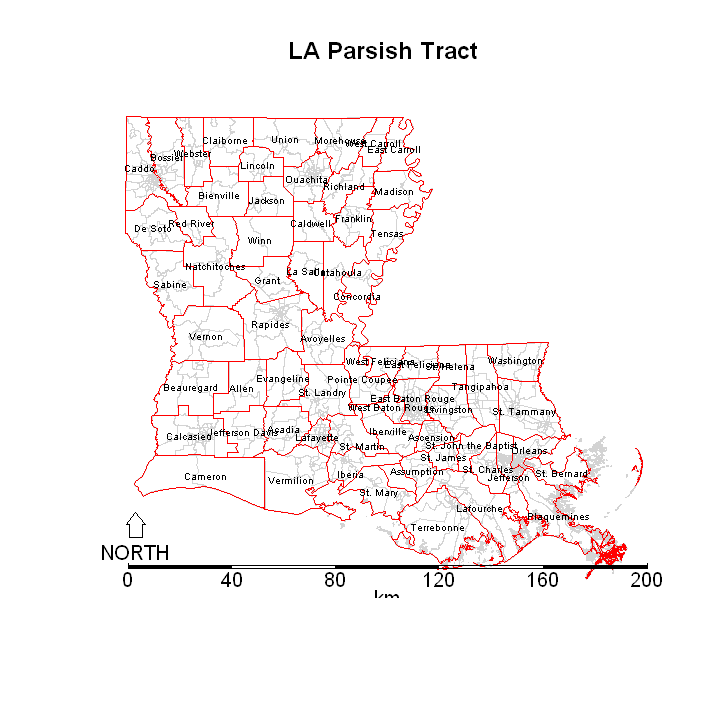

In [22]:
# parish = counties
# tracts = census


plot(census, border = "lightgray", 
         col = "white", 
         main = "LA Parsish Tract")

plot(counties, border = "red", add = TRUE)

# get centroid of polygons
centroids <- gCentroid(counties, byid = TRUE)
centroidLons <- coordinates(centroids)[ , 1]
centroidLats <- coordinates(centroids)[ , 2]

# label with country name
text(centroidLons, centroidLats, 
         labels = counties$formattedName,
         cex = 0.5
    )

north.arrow(xb_min + 10000, yb_min + 40000, len = 6000, lab = "NORTH")

map.scale(xb_min + 255000, yb_min + 10000, len = 505000, 
          units = "km", ndiv = 5, subdiv = 40)

Randomly sample 4 parishes. Map the selected parishes in red (fill) and display all other counties in white. 

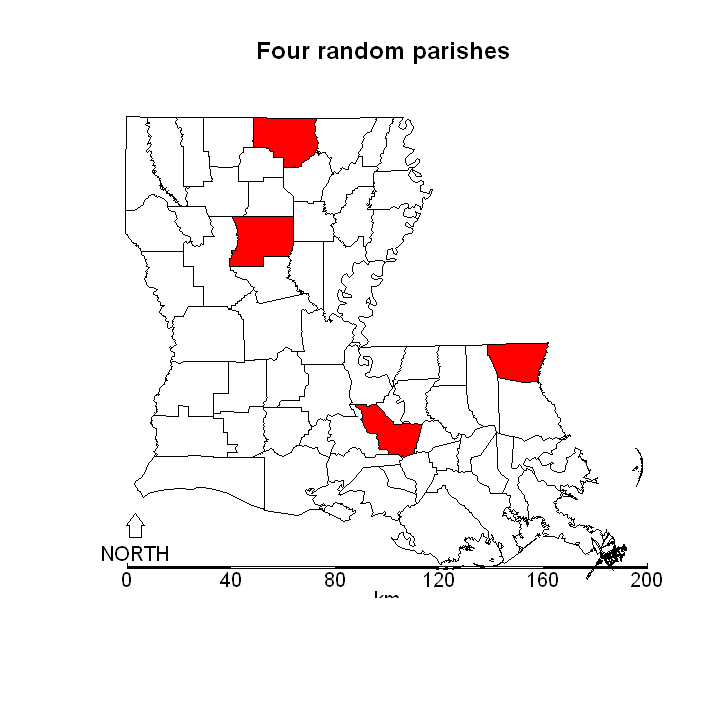

In [23]:
n <- 4

N <- length(counties)

samp.rand <- counties[sample(N, n), ]

plot(counties, col = "white", main = "Four random parishes")

plot(samp.rand, col = "red", add = TRUE)

north.arrow(xb_min + 10000, yb_min + 40000, len = 6000, lab = "NORTH")

map.scale(xb_min + 255000, yb_min + 10000, len = 505000, 
          units = "km", ndiv = 5, subdiv = 40)

Select all Census tracts that are completely within the 4 randomly sampled parishes. Map all of the counties in white (fill) and the selected tracts with red borders.  Be sure to add an appropriate map title and include a scalebar and north arrow. 

Given that Census tract polygon borders don't necessarily line up perfectly with parish polygon borders, you'll have to introduce a fudge factor (i.e. 1000 meters) when executing this spatial query. 

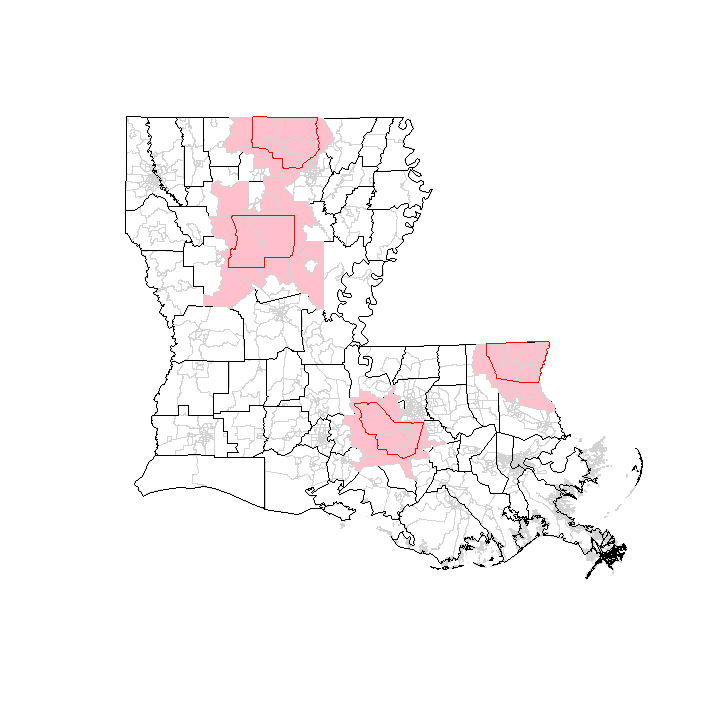

In [24]:
# let's buffer the random samples a bit and round them out

samp.rand.buf <- gBuffer(samp.rand, byid = TRUE, 
                         id = NULL, 
                         width = 1000, 
                         capStyle = "ROUND", 
                         joinStyle = "ROUND",
                         mitreLimit = 1.0
                        )

selFeat <- overGeomGeom(samp.rand.buf, census, returnList = TRUE, fn = NULL)
intSet <- unlist(selFeat)
intFeat <- census[intSet, ]

plot(census, col = "white", border = "lightgray")
plot(counties, add = TRUE)
plot(intFeat, col = "pink", border = "lightgray", add = TRUE)
plot(samp.rand.buf, border = "red", add = TRUE)

In [25]:
i <- 1

containedList <- list()

for (subsel in selFeat){
    for (ele in subsel){
        if (gContains(samp.rand.buf, census[ele, ], byid = FALSE, prepared = TRUE,
                         returnDense = TRUE, STRsubset = FALSE, checkValidity = FALSE)){
            containedList[[i]] <- ele
            i <- i + 1
        }
    }
}

contSet <- unlist(containedList)
length(contSet)

[1] 28

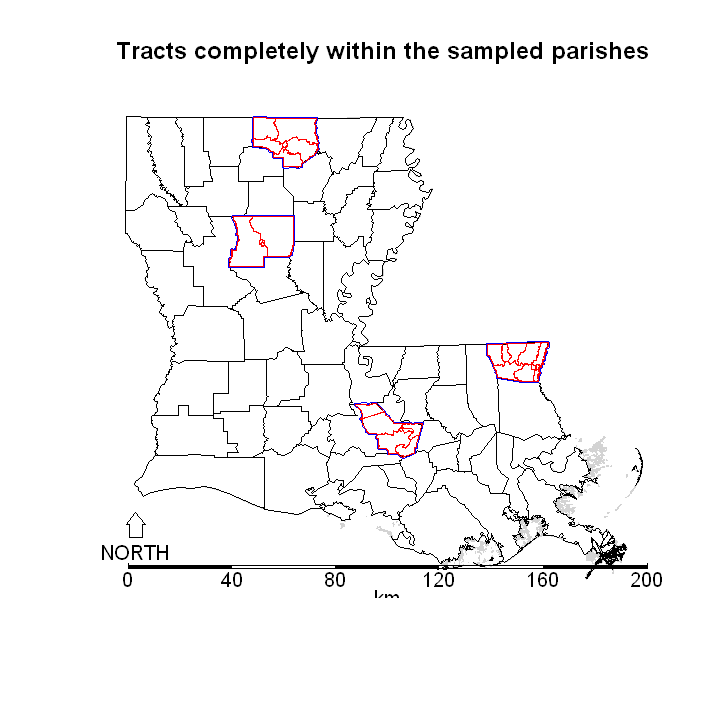

In [26]:
conFeat <- census[contSet, ]

plot(census, border = "lightgray", main = "Tracts completely within the sampled parishes")
plot(counties, col = "white", add = TRUE)
plot(samp.rand.buf, border = "blue", add = TRUE)
plot(conFeat, border = "red", add = TRUE)

north.arrow(xb_min + 10000, yb_min + 40000, len = 6000, lab = "NORTH")

map.scale(xb_min + 255000, yb_min + 10000, len = 505000, 
          units = "km", ndiv = 5, subdiv = 40)

Randomly sample 20% of the Census tracts from those contained within the sampled parishes. Assign larger tracts (more area i.e. square miles) a larger probability of being sampled. 

In [27]:
head(conFeat@data)

,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2010,POP10_SQMI,...,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI
1136,29342,22,127,22127,960100,22127960100,4155,8.5,3780,7.7,...,507,48,100,1077,2.96,2091,609,1214,268,490.13
1137,29343,22,127,22127,960200,22127960200,6523,14.2,6146,13.6,...,628,52,134,1310,2.98,2571,700,1625,246,458.24
1138,29344,22,127,22127,960300,22127960300,3449,939.8,2934,978.0,...,235,31,210,758,3.10,1448,293,694,461,3.67
1139,29345,22,127,22127,960400,22127960400,2767,582.5,2453,613.3,...,167,16,205,614,3.17,1124,163,466,495,4.75
1073,29279,22,111,22111,960100,22111960100,4027,12.1,4240,13.0,...,529,38,182,1202,3.00,2261,559,1324,378,331.76
1074,29280,22,111,22111,960200,22111960200,4167,23.5,3712,21.1,...,484,50,153,1077,2.97,1819,342,1195,282,177.09


In [28]:
N <- length(conFeat) # total contained tracts
n <- round(N * 0.20) # sample size (20%)

n 

[1] 6

In [29]:
pr1 <- c(conFeat$SQMI) / max(conFeat$SQMI)

pr1[1:20]

[1] 1.000000000 0.934935629 0.007487809 0.009691306 0.676881644 0.361312305
 [7] 0.211250077 0.016689450 0.356721686 0.224389448 0.182053741 0.440699406
[13] 0.379123906 0.174321098 0.007079754 0.027890560 0.120723073 0.132413849
[19] 0.246669251 0.193234448

In [30]:
samp.rand <- conFeat[sample(N, n, prob = pr1), ]

length(samp.rand)

[1] 6

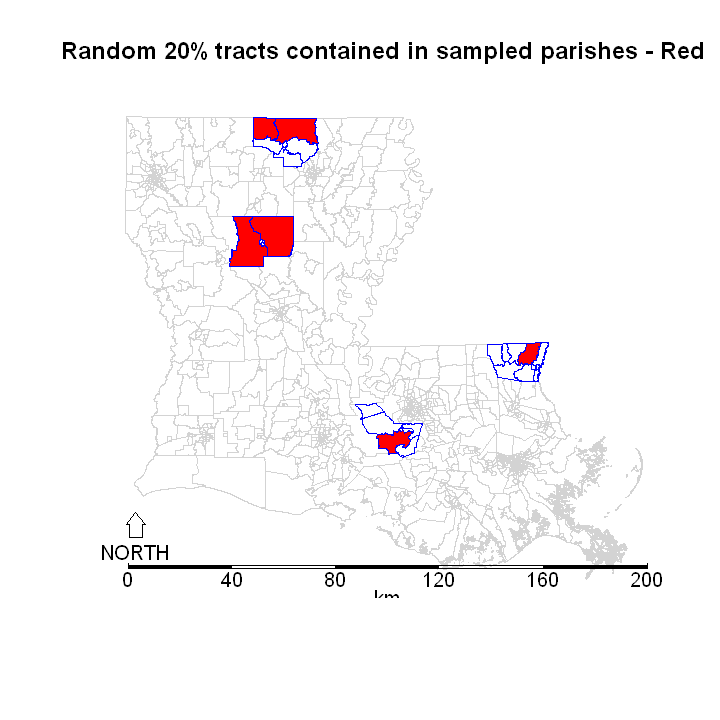

In [31]:
plot(census, border = "lightgray", 
         main = "Random 20% tracts contained in sampled parishes - Red")

plot(conFeat, border = "blue", add = TRUE)

plot(samp.rand, col = "red", border = "blue", add = TRUE)

north.arrow(xb_min + 10000, yb_min + 40000, len = 6000, lab = "NORTH")

map.scale(xb_min + 255000, yb_min + 10000, len = 505000, 
          units = "km", ndiv = 5, subdiv = 40)

Point sampling. For each of the 20% random sample of tracts that are within the set of randomly selected parishes, generate a sample of 5 points according to each of the three different sampling methods - random, regular, and clustered. This task should be automated using some iterative process.  Map the results adding an appropriate map title that states the name of the parish, the id of the tract 'TRACT', and the sampling method used to generate the sample of points. 


Each map must depict the border of the parish within which a tract is contained in gray, the border of the tract in red, and the sampled points.


In [32]:
head(samp.rand@data, 2)

,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2010,POP10_SQMI,...,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI
1137,29343,22,127,22127,960200,22127960200,6523,14.2,6146,13.6,...,628,52,134,1310,2.98,2571,700,1625,246,458.24
1136,29342,22,127,22127,960100,22127960100,4155,8.5,3780,7.7,...,507,48,100,1077,2.96,2091,609,1214,268,490.13


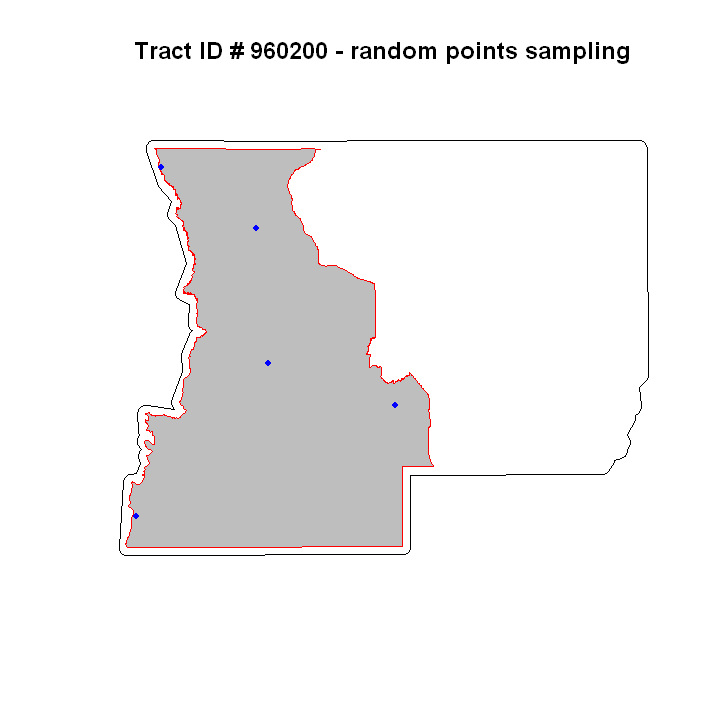

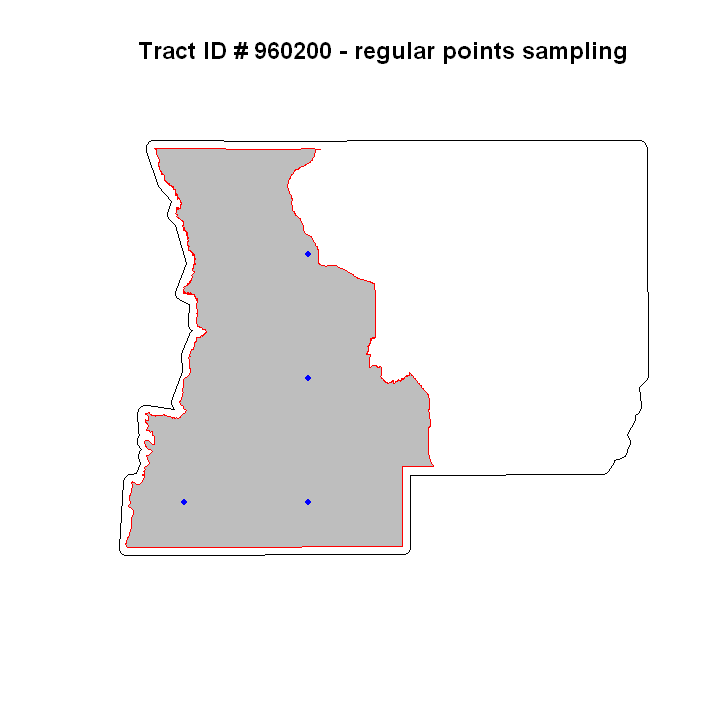

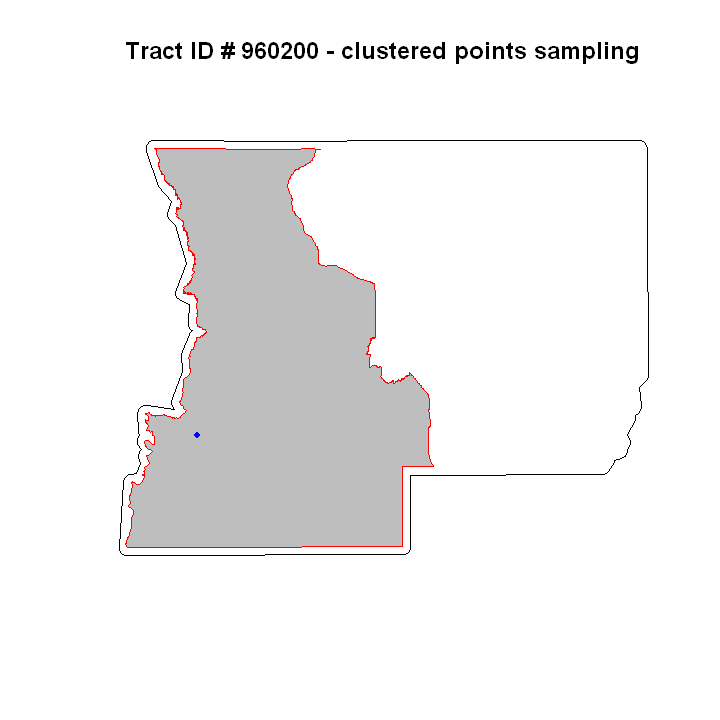

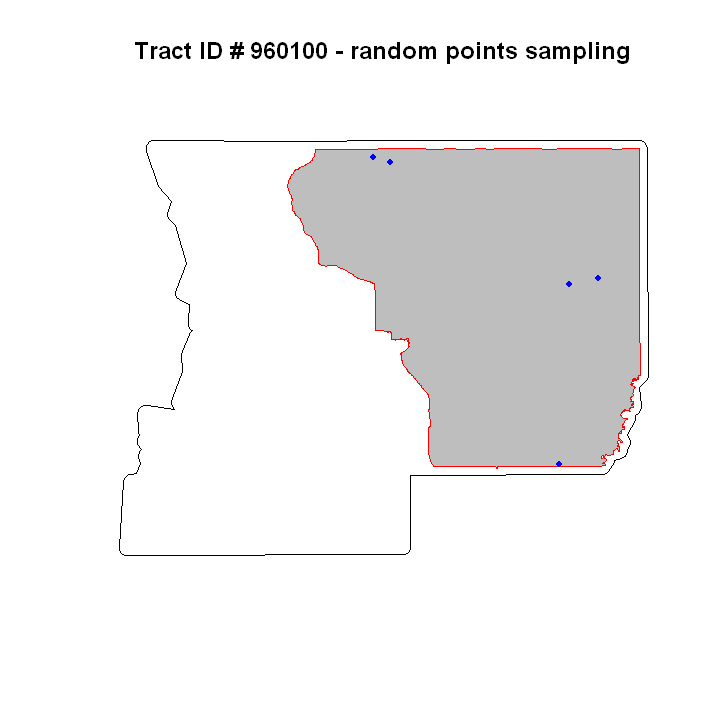

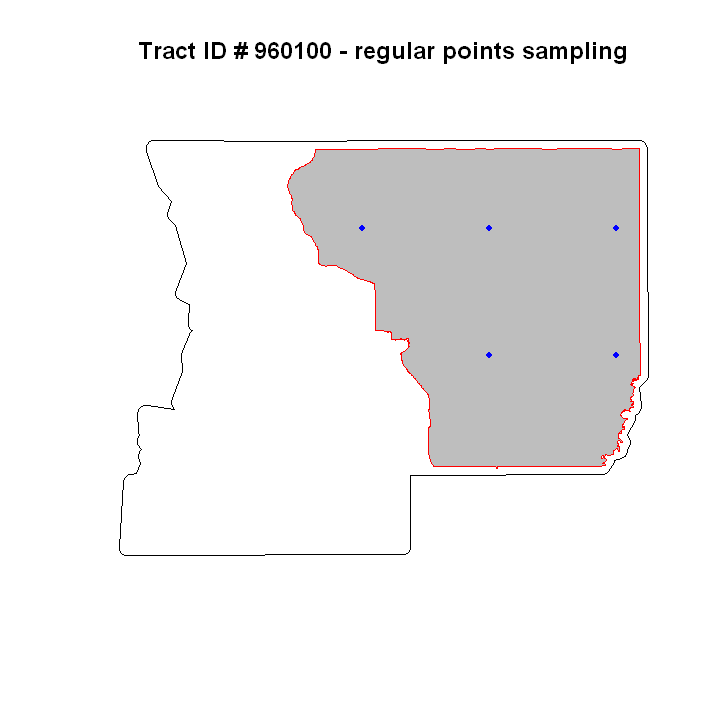

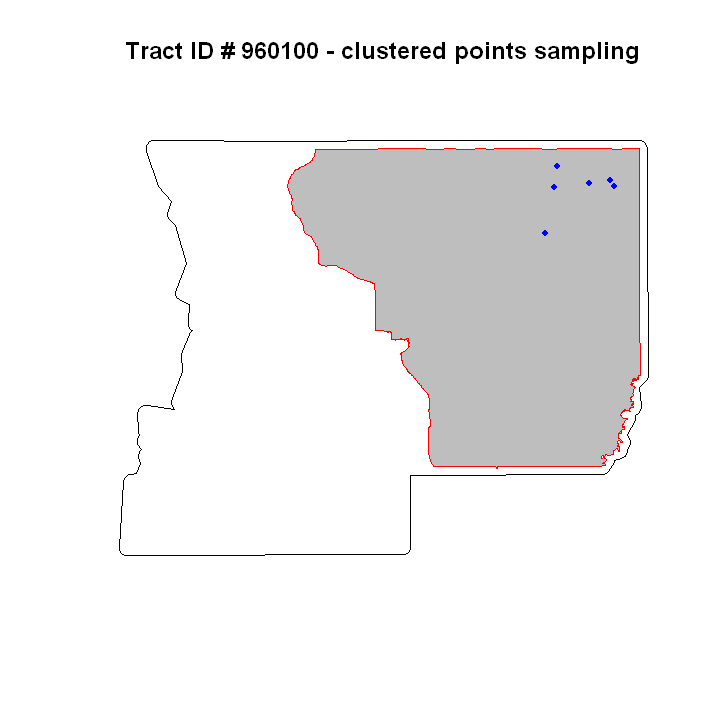

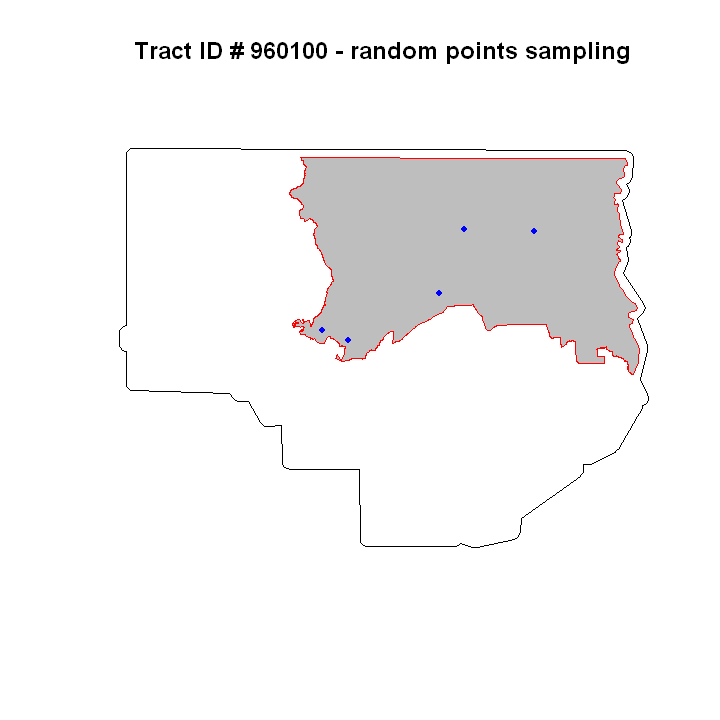

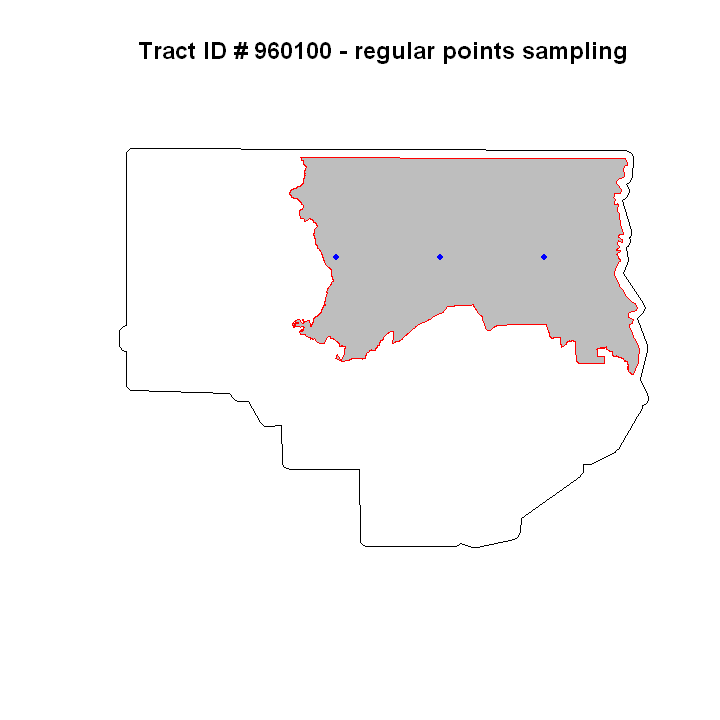

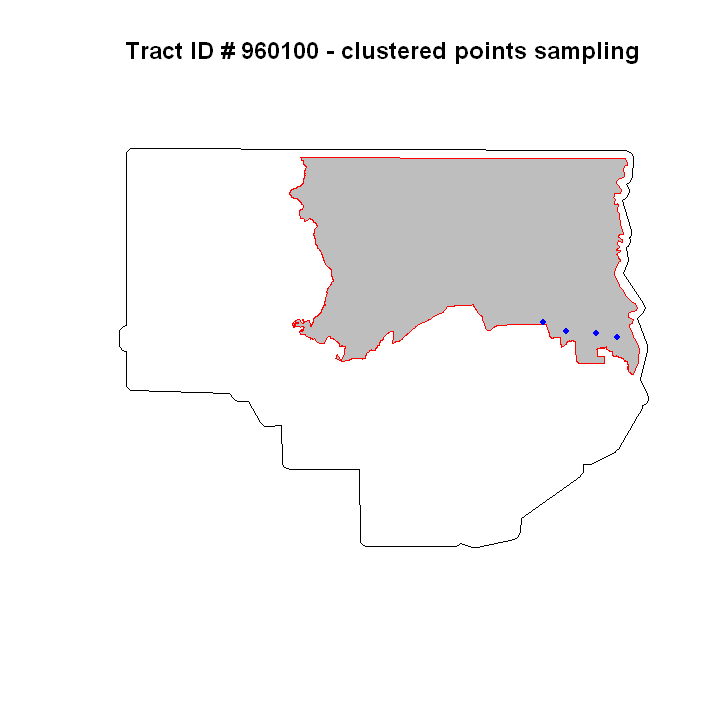

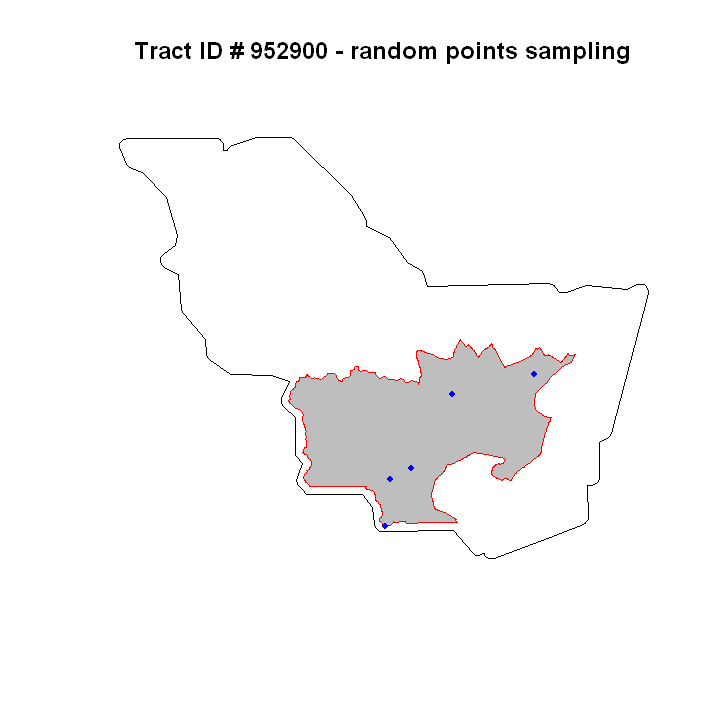

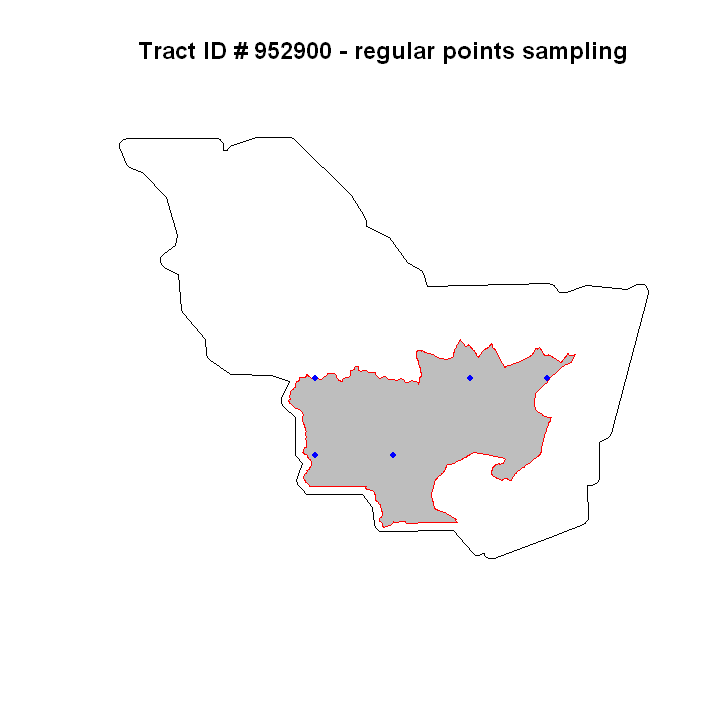

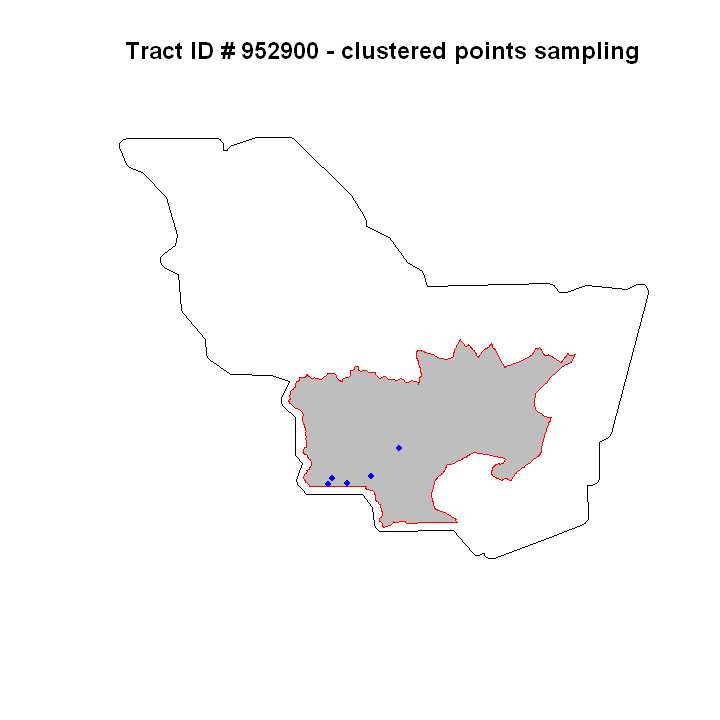

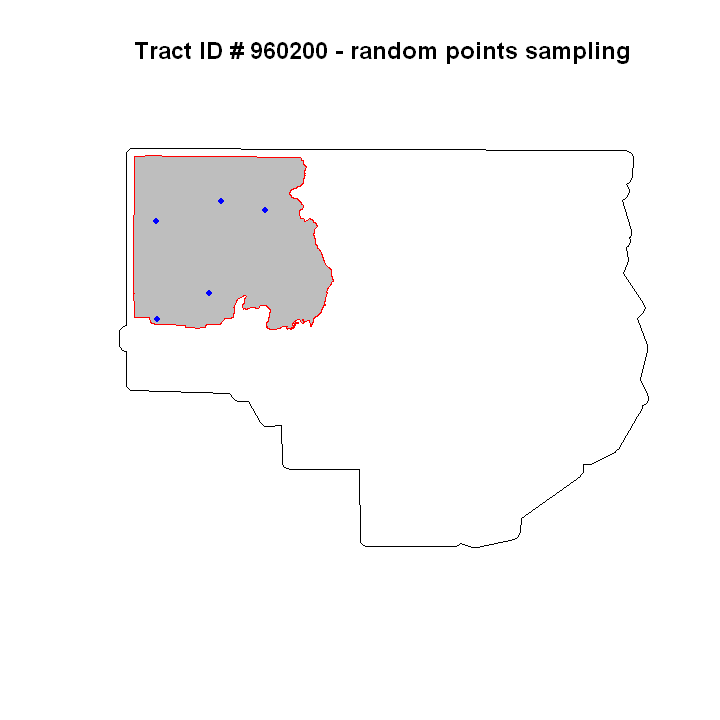

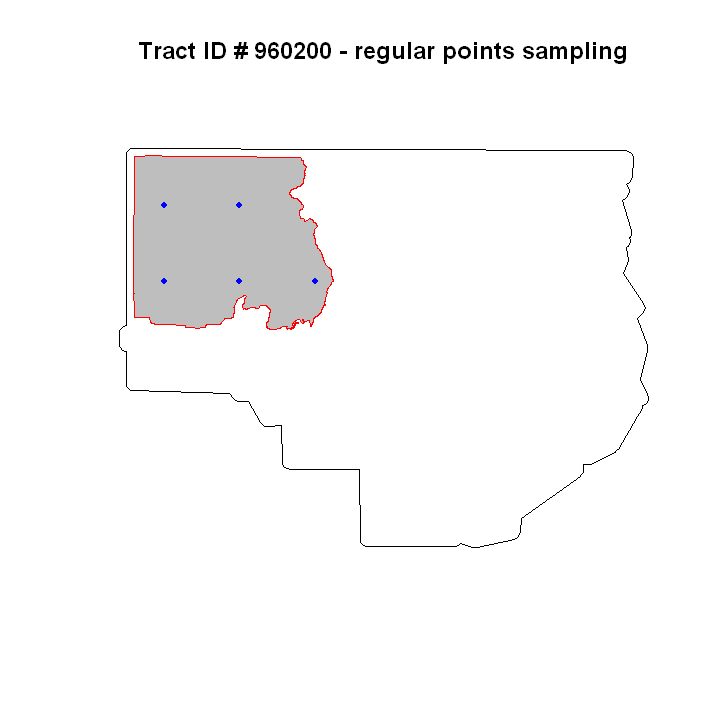

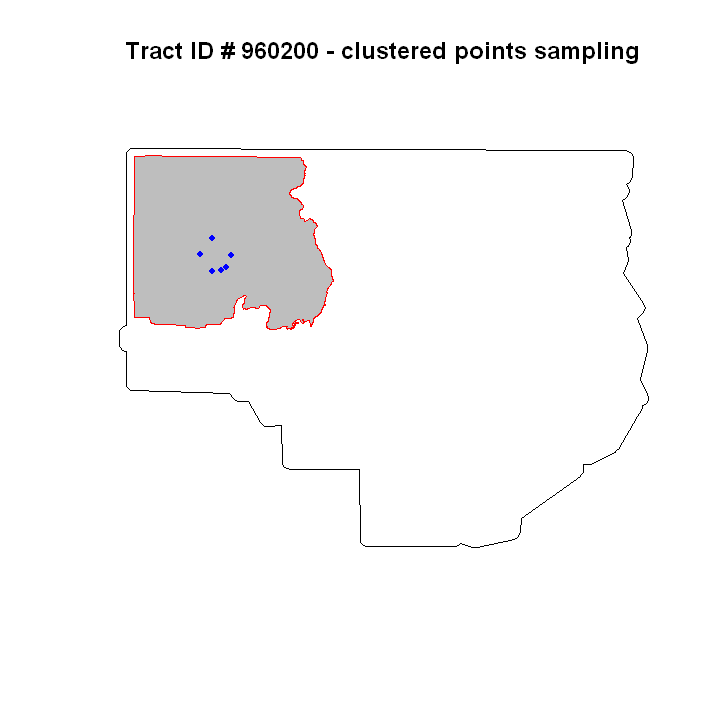

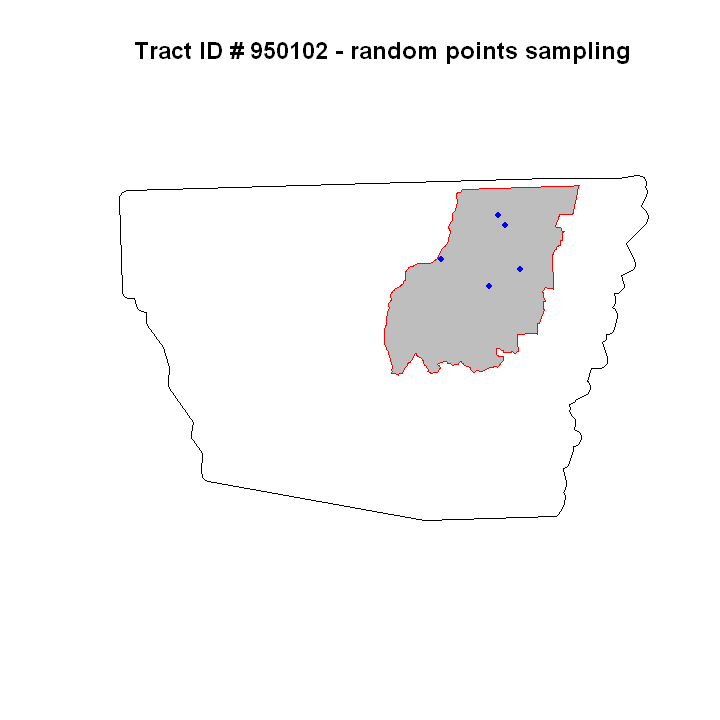

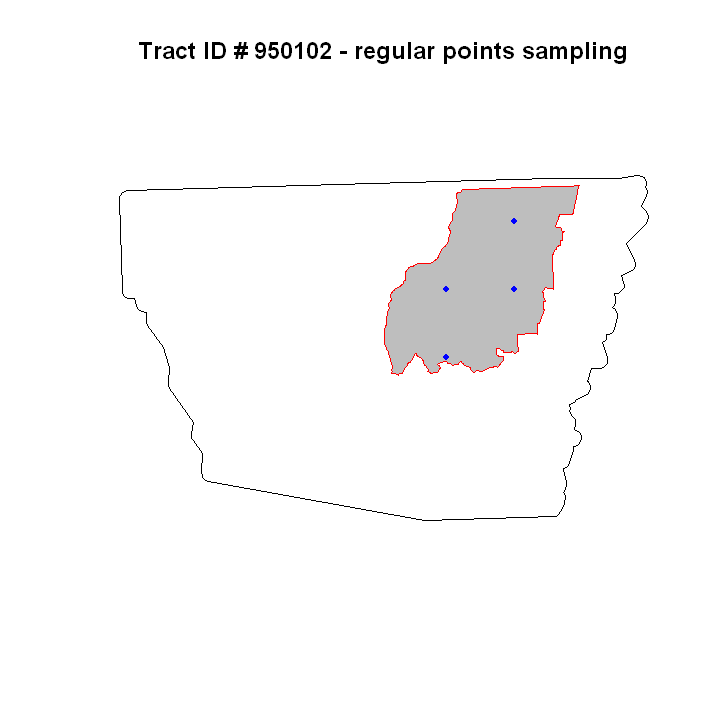

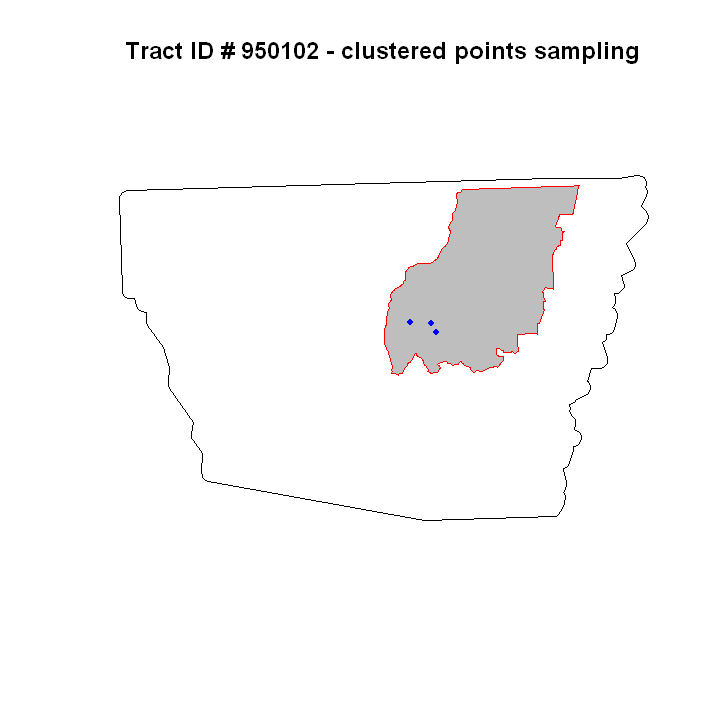

In [33]:
methods <- c("random", "regular", "clustered")

for (i in 1:nrow(samp.rand)){
    n <- 5
    selFeat <- samp.rand[i, ]
    tractId <- as.character(selFeat$TRACT)
    
    conParish <- ""
    
    for (j in 1:nrow(samp.rand.buf)){
        cont <- samp.rand.buf[j, ]        
        
        if (gContains(cont, selFeat)){
            conParish <- cont
        }
    }
    
    for (m in methods){
        sp <- spsample(selFeat, n, type = m)
        
        plot(conParish, main = paste("Tract ID #", tractId, "-", m, "points sampling"))
        
        plot(selFeat, col = "gray", border = "red", add = TRUE)      
        
        plot(sp, add = TRUE, col = "blue", pch = 20)
    }  
}